In [1]:
%matplotlib inline
%pip install imagehash
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.fft import fft2,fftshift
from scipy.spatial.distance import hamming
from skimage.io import imread, imread_collection, imshow, imshow_collection
from skimage.transform import resize, rescale, rotate
from skimage.color import rgb2gray
import os
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.models import Model
import ast
from collections import Counter
from PIL import Image
import imagehash
from itertools import combinations

# Working with Images Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll work with images of felines (cats), which have been classified according to their taxonomy. Each subfolder contains images of a particular species. The dataset is located [here](https://www.kaggle.com/datasets/datahmifitb/felis-taxonomy-image-classification) but it's also provided to you in the `data/` folder.

### Problem 1. Some exploration (1 point)
How many types of cats are there? How many images do we have of each? What is a typical image size? Are there any outliers in size?

In [3]:
cat_collection = imread_collection("data/*")

In [4]:
cat_collection2 = imread_collection("data/*/*")

In [5]:
cat_collection2[0]

array([[[153, 119,  81],
        [153, 119,  81],
        [153, 119,  81],
        ...,
        [128, 107,  64],
        [128, 107,  64],
        [129, 108,  65]],

       [[153, 119,  81],
        [153, 119,  81],
        [153, 119,  81],
        ...,
        [128, 107,  64],
        [128, 107,  64],
        [129, 108,  65]],

       [[153, 119,  81],
        [153, 119,  81],
        [153, 119,  81],
        ...,
        [129, 108,  65],
        [128, 107,  64],
        [129, 108,  65]],

       ...,

       [[116, 116, 116],
        [250, 250, 250],
        [252, 252, 252],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[116, 116, 116],
        [250, 250, 250],
        [252, 252, 252],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[116, 116, 116],
        [250, 250, 250],
        [252, 252, 252],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [6]:
len(cat_collection)

7

In [7]:
arr = os.listdir("data")

In [8]:
subdirectories = [file.path for file in os.scandir("data/") if file.is_dir()]

In [9]:
arr, subdirectories

(['blackfoot-cat',
  'jungle-cat',
  '.DS_Store',
  'chinese-mountain-cat',
  'sand-cat',
  'domestic-cat',
  'african-wildcat',
  'european-wildcat'],
 ['data/blackfoot-cat',
  'data/jungle-cat',
  'data/chinese-mountain-cat',
  'data/sand-cat',
  'data/domestic-cat',
  'data/african-wildcat',
  'data/european-wildcat'])

In [10]:
# for item in arr:
#     # Check if the item is a directory
#     if os.path.isdir(os.path.join("data", item)):
#         collection = imread_collection(path)
#         exec("item = collection")

In [11]:
for folder in range(0, len(arr)-1):
     path = "data/" + arr[folder] + "/*"
     print(arr[folder], len(imread_collection(path)))

blackfoot-cat 78
jungle-cat 80
.DS_Store 0
chinese-mountain-cat 37
sand-cat 69
domestic-cat 60
african-wildcat 87


In [12]:
subdirectories_names = [os.path.join("data", d) for d in os.listdir("data") if os.path.isdir(os.path.join("data", d))]
subdirectories_names

['data/blackfoot-cat',
 'data/jungle-cat',
 'data/chinese-mountain-cat',
 'data/sand-cat',
 'data/domestic-cat',
 'data/african-wildcat',
 'data/european-wildcat']

In [13]:
blackfoot_cats = imread_collection("data/blackfoot-cat/*")
jungle_cats = imread_collection("data/jungle-cat/*")
chinese_mountain_cats = imread_collection("data/chinese-mountain-cat/*")
sand_cats = imread_collection("data/sand-cat/*")
domestic_cats = imread_collection("data/domestic-cat/*")
african_wildcats = imread_collection("data/african-wildcat/*")
european_wildcats = imread_collection("data/european-wildcat/*")


In [14]:
blackfoot_size =[ blackfoot_cats[i].shape for i in range(0, len(blackfoot_cats))]
blackfoot_type_size = Counter(blackfoot_size)
jungle_size =[ jungle_cats[i].shape for i in range(0, len(jungle_cats))]
jungle_type_size = Counter(jungle_size)
chinese_mountain_size =[ chinese_mountain_cats[i].shape for i in range(0, len(chinese_mountain_cats))]
chinese_mountain_type_size = Counter(chinese_mountain_size)
sand_size =[ sand_cats[i].shape for i in range(0, len(sand_cats))]
sand_type_size = Counter(sand_size)
domestic_size =[domestic_cats[i].shape for i in range(0, len(domestic_cats))]
domestic_type_size = Counter(domestic_size)
african_size =[african_wildcats[i].shape for i in range(0, len(african_wildcats))]
african_type_size = Counter(african_size)
european_size =[european_wildcats[i].shape for i in range(0, len(european_wildcats))]
european_type_size = Counter(european_size)

In [15]:
blackfoot_type_size.most_common(5), jungle_type_size.most_common(5), chinese_mountain_type_size.most_common(5), sand_type_size.most_common(5), domestic_type_size.most_common(5), african_type_size.most_common(5), european_type_size.most_common(5)

([((183, 275, 3), 11),
  ((275, 183, 3), 7),
  ((192, 262, 3), 4),
  ((276, 183, 3), 4),
  ((183, 276, 3), 3)],
 [((183, 275, 3), 20),
  ((194, 259, 3), 8),
  ((275, 183, 3), 3),
  ((187, 270, 3), 3),
  ((201, 251, 3), 3)],
 [((183, 275, 3), 4),
  ((500, 800, 3), 3),
  ((477, 636, 3), 2),
  ((3000, 4000, 3), 2),
  ((168, 299, 3), 2)],
 [((183, 275, 3), 21),
  ((194, 259, 3), 7),
  ((225, 225, 3), 6),
  ((201, 251, 3), 2),
  ((259, 194, 3), 2)],
 [((183, 275, 3), 21),
  ((194, 259, 3), 6),
  ((225, 225, 3), 4),
  ((190, 265, 3), 3),
  ((200, 252, 3), 2)],
 [((183, 275, 3), 24),
  ((192, 262, 3), 6),
  ((225, 225, 3), 5),
  ((168, 300, 3), 5),
  ((194, 259, 3), 4)],
 [((1333, 2000, 3), 3),
  ((956, 1300, 3), 3),
  ((183, 275, 3), 3),
  ((417, 626, 3), 2),
  ((600, 800, 3), 2)])

In [16]:
# for index in range(0, len(blackfoot_type_size)):
#     print(blackfoot_type_size[index].key, blackfoot_type_size[index].value)
blackfoot_type_once = [key for key,value in blackfoot_type_size.items() if value ==1 ]
blackfoot_type_once

[(267, 189, 3),
 (182, 277, 3),
 (211, 239, 3),
 (195, 259, 3),
 (201, 251, 3),
 (243, 207, 3),
 (199, 253, 3),
 (194, 259, 3),
 (278, 182, 3),
 (176, 287, 3),
 (194, 260, 3),
 (175, 220, 3),
 (167, 302, 3),
 (274, 184, 3),
 (181, 278, 3),
 (181, 279, 3),
 (196, 257, 3),
 (184, 274, 3),
 (128, 250, 3),
 (169, 299, 3),
 (276, 182, 3),
 (203, 249, 3),
 (177, 284, 3),
 (184, 275, 3),
 (214, 235, 3),
 (182, 278, 3),
 (273, 184, 3),
 (189, 267, 3),
 (210, 240, 3),
 (168, 299, 3),
 (223, 226, 3)]

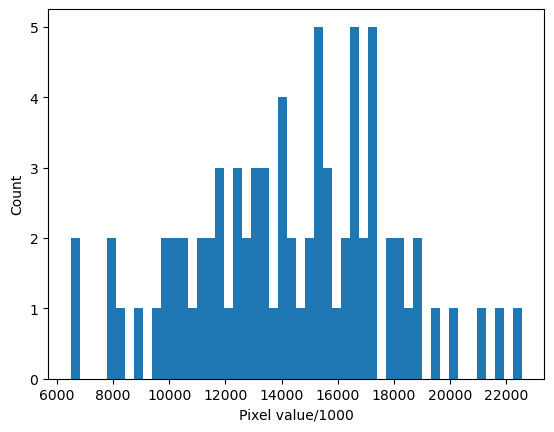

In [17]:
blackfoot_cats_reds = [image.ravel().sum()/1000 for image in blackfoot_cats]
plt.hist(blackfoot_cats_reds, bins = 50)

plt.xlabel("Pixel value/1000")
plt.ylabel("Count")

plt.show()

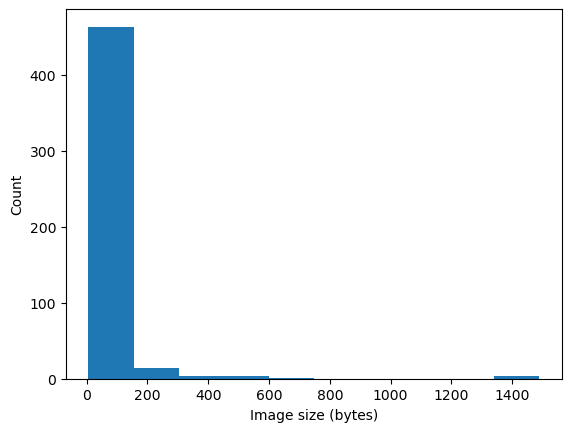

In [18]:
sizes = []
size_dict = {}
for dirpath, dirnames, filenames in os.walk("data"):
    for filename in filenames:
        img_path = os.path.join(dirpath, filename)
        size = os.path.getsize(img_path)
        sizes.append(size/1000)
        size_dict[img_path] = size
        
plt.hist(sizes, bins = 10)

plt.xlabel("Image size (bytes)")
plt.ylabel("Count")
plt.show()

In [19]:
for path, size in size_dict.items():
    if size/1000 > 600:
        print(path, size)

data/chinese-mountain-cat/ch (7).jpg 733577
data/chinese-mountain-cat/ch (19).jpg 1399835
data/chinese-mountain-cat/ch (14).jpg 1489457
data/chinese-mountain-cat/.ipynb_checkpoints/ch (19)-checkpoint.jpg 1399835


#### There are 7 types of cats: Blackfoot, Jungle, Chinese mountain, Sand, Domestic and African cat. 
Blackfoot have 79 images, Jungle have 86 images, Chinese mountain have 42 images, Sand - 72 images, Domestic - 64 images, African - 91 images. The most typical image size is 183, 275,3. There are outliers images as we can see above - chinese-mountain-cat/ch (19).jpg,data/chinese-mountain-cat/ch (14).jpg and data/chinese-mountain-cat/ch (14).jpg

### Problem 2. Duplicat(e)s (1 point)
Find a way to filter out (remove) identical images. I would recommnend using file hashes, but there are many approaches. Keep in mind that during file saving, recompression, etc., a lot of artifacts can change the file content (bytes), but not visually.

In [20]:
hashes = {}
dict_hashes = {}
bin_hash = {}

similarity = 90
for cat_directory in subdirectories:
    files_img = os.listdir(cat_directory)
    for file in files_img:
        path_image = os.path.join(cat_directory, file)
        if os.path.isdir(path_image):
            continue
        else:
           with Image.open(path_image) as img:
               temp_hash = imagehash.average_hash(img, hash_size = 8)
               hex_hash_val = imagehash.whash(img)
               if temp_hash in hashes: 
                   os.remove(path_image)
               else:
                    hashes[temp_hash] = file
                    dict_hashes[path_image] = str(temp_hash)
                    bin_hash[path_image] = temp_hash.hash.astype('int').flatten()
           

In [21]:
for (key1, val1), (key2, val2) in combinations(bin_hash.items(), 2):
    dist = hamming(val1, val2)
    if dist < 0.02:
        print(key1, key2, dist)

data/blackfoot-cat/bc (24).jpg data/blackfoot-cat/bc (30).jpg 0.015625
data/blackfoot-cat/bc (73).jpg data/blackfoot-cat/bc (79).jpg 0.015625
data/sand-cat/sd (56).jpg data/sand-cat/sd (35).jpg 0.015625
data/sand-cat/sd (22).jpg data/sand-cat/sd (24).jpg 0.015625
data/african-wildcat/af (29).jpg data/european-wildcat/eu (33).jpg 0.015625
data/african-wildcat/af (68).jpg data/european-wildcat/eu (50).jpg 0.015625
data/african-wildcat/af (32).jpg data/african-wildcat/af (27).jpg 0.015625
data/african-wildcat/af (74).jpg data/african-wildcat/af (16).jpg 0.015625
data/african-wildcat/af (37).jpg data/african-wildcat/af (11).jpg 0.015625
data/african-wildcat/af (61).jpg data/african-wildcat/af (50).jpg 0.015625
data/african-wildcat/af (85).jpg data/european-wildcat/eu (7).jpg 0.015625


### Problem 3. Loading a model (2 points)
Find a suitable, trained convolutional neural network classifier. I recommend `ResNet50` as it's small enough to run well on any machine and powerful enough to make reasonable predictions. Most ready-made classifiers have been trained for 1000 classes.

You'll need to install libraries and possibly tinker with configurations for this task. When you're done, display the total number of layers and the total number of parameters. For ResNet50, you should expect around 50 layers and 25M parameters.

In [22]:
model = ResNet50()

In [23]:
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [24]:
model.layers

[<InputLayer name=input_layer, built=True>,
 <ZeroPadding2D name=conv1_pad, built=True>,
 <Conv2D name=conv1_conv, built=True>,
 <BatchNormalization name=conv1_bn, built=True>,
 <Activation name=conv1_relu, built=True>,
 <ZeroPadding2D name=pool1_pad, built=True>,
 <MaxPooling2D name=pool1_pool, built=True>,
 <Conv2D name=conv2_block1_1_conv, built=True>,
 <BatchNormalization name=conv2_block1_1_bn, built=True>,
 <Activation name=conv2_block1_1_relu, built=True>,
 <Conv2D name=conv2_block1_2_conv, built=True>,
 <BatchNormalization name=conv2_block1_2_bn, built=True>,
 <Activation name=conv2_block1_2_relu, built=True>,
 <Conv2D name=conv2_block1_0_conv, built=True>,
 <Conv2D name=conv2_block1_3_conv, built=True>,
 <BatchNormalization name=conv2_block1_0_bn, built=True>,
 <BatchNormalization name=conv2_block1_3_bn, built=True>,
 <Add name=conv2_block1_add, built=True>,
 <Activation name=conv2_block1_out, built=True>,
 <Conv2D name=conv2_block2_1_conv, built=True>,
 <BatchNormalization na

In [25]:
len(model.layers)

177

#### There are 25,636,712 parameters and 177 layers

### Problem 4. Prepare the images (1 point)
You'll need to prepare the images for passing to the model. To do so, they have to be resized to the same dimensions. Most available models have a specific requirement for sizes. You may need to do additional preprocessing, depending on the model requirements. These requirements should be easily available in the model documentation.

In [26]:
blackfoot_cats_no_dup = imread_collection("data/blackfoot-cat/*")
jungle_cats_no_dup = imread_collection("data/jungle-cat/*")
chinese_mountain_cats_no_dup = imread_collection("data/chinese-mountain-cat/*")
sand_cats_no_dup = imread_collection("data/sand-cat/*")
domestic_cats_no_dup = imread_collection("data/domestic-cat/*")
african_wildcats_no_dup = imread_collection("data/african-wildcat/*")
european_wildcats_no_dup = imread_collection("data/european-wildcat/*")


In [38]:
def resize_col(cat_img):
    return resize(cat_img, (224, 224))
    
blackffot_cats_resized = [resize_col(cat) for cat in blackfoot_cats_no_dup]
jungle_cats_resized = [resize_col(cat) for cat in jungle_cats_no_dup] 
chinese_mountain_cats_resized = [resize_col(cat) for cat in chinese_mountain_cats_no_dup] 
sand_cats_resised = [resize_col(cat) for cat in sand_cats_no_dup] 
domestic_cats_resized = [resize_col(cat) for cat in domestic_cats_no_dup] 
african_wildcats_resized = [resize_col(cat) for cat in african_wildcats_no_dup] 
european_wildcats_resized = [resize_col(cat) for cat in european_wildcats_no_dup] 

### Problem 5. Load the images efficiently (1 point)
Now that you've seen how to prepare the images for passing to the model... find a way to do it efficiently. Instead of loading the entire dataset in the RAM, read the images in batches (e.g. 4 images at a time). The goal is to read these, preprocess them, maybe save the preprocessed results in RAM.

If you've already done this in one of the previous problems, just skip this one. You'll get your point for it.

\* Even better, save the preprocessed image arrays (they will not be valid .jpg file) as separate files, so you can load them "lazily" in the following steps. This is a very common optimization to work with large datasets.

In [42]:
blackffot_cats_resized_preprocess = [preprocess_input(cat) for cat in blackffot_cats_resized ]

### Problem 6. Predictions (1 point)
Finally, you're ready to get into the meat of the problem. Obtain predictions from your model and evaluate them. This will likely involve manual work to decide how the returned classes relate to the original ones.

Create a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to evaluate the classification.

In [44]:
prediction = model.predict(np.array(blackffot_cats_resized_preprocess)) 

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step


In [94]:
prediction.shape

(78, 1000)

In [91]:
decode_predictions(np.array(prediction))

[[('n03196217', 'digital_clock', 0.41129428),
  ('n01930112', 'nematode', 0.053953566),
  ('n04286575', 'spotlight', 0.0415139),
  ('n09229709', 'bubble', 0.039615545),
  ('n03729826', 'matchstick', 0.035703804)],
 [('n03196217', 'digital_clock', 0.39430875),
  ('n01930112', 'nematode', 0.055855207),
  ('n04286575', 'spotlight', 0.04271974),
  ('n09229709', 'bubble', 0.040457193),
  ('n03729826', 'matchstick', 0.03619509)],
 [('n03196217', 'digital_clock', 0.3910587),
  ('n01930112', 'nematode', 0.056350004),
  ('n04286575', 'spotlight', 0.042714138),
  ('n09229709', 'bubble', 0.041135743),
  ('n03729826', 'matchstick', 0.036876217)],
 [('n03196217', 'digital_clock', 0.37917873),
  ('n01930112', 'nematode', 0.05992477),
  ('n04286575', 'spotlight', 0.043423332),
  ('n09229709', 'bubble', 0.041360967),
  ('n03729826', 'matchstick', 0.036067232)],
 [('n03196217', 'digital_clock', 0.39875737),
  ('n01930112', 'nematode', 0.055282522),
  ('n04286575', 'spotlight', 0.04248865),
  ('n0922970

In [50]:
for pr_num in range(len(prediction)):
    decode_predictions(np.array([prediction[pr_num]]))

In [52]:
model.layers

[<InputLayer name=input_layer, built=True>,
 <ZeroPadding2D name=conv1_pad, built=True>,
 <Conv2D name=conv1_conv, built=True>,
 <BatchNormalization name=conv1_bn, built=True>,
 <Activation name=conv1_relu, built=True>,
 <ZeroPadding2D name=pool1_pad, built=True>,
 <MaxPooling2D name=pool1_pool, built=True>,
 <Conv2D name=conv2_block1_1_conv, built=True>,
 <BatchNormalization name=conv2_block1_1_bn, built=True>,
 <Activation name=conv2_block1_1_relu, built=True>,
 <Conv2D name=conv2_block1_2_conv, built=True>,
 <BatchNormalization name=conv2_block1_2_bn, built=True>,
 <Activation name=conv2_block1_2_relu, built=True>,
 <Conv2D name=conv2_block1_0_conv, built=True>,
 <Conv2D name=conv2_block1_3_conv, built=True>,
 <BatchNormalization name=conv2_block1_0_bn, built=True>,
 <BatchNormalization name=conv2_block1_3_bn, built=True>,
 <Add name=conv2_block1_add, built=True>,
 <Activation name=conv2_block1_out, built=True>,
 <Conv2D name=conv2_block2_1_conv, built=True>,
 <BatchNormalization na

In [53]:
feature_extractor = Model(inputs = model.inputs, outputs = model.layers[24].output )

In [54]:
feature_extractor.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 140,544 (549.00 KB)

 Trainable params: 138,880 (542.50 KB)

 Non-trainable params: 1,664 (6.50 KB)

In [63]:
result_blackfoot_cats = feature_extractor.predict(([np.array(blackffot_cats_resized_preprocess)]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step


In [90]:
decode_predictions(np.array(result_blackfoot_cats))

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Received array with shape: (78, 56, 56, 64)

In [64]:
cos_dim = lambda a,b: np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

0.98058067569092

In [68]:
cos_dim_fl = lambda a, b: np.dot(a.flatten(), b.flatten()) / (np.linalg.norm(a.flatten()) * np.linalg.norm(b.flatten()))

In [74]:
def similarity(cats_array):
    cos_similarity = []
    for a,b in combinations(cats_array,2):
        cos_similarity.append(cos_dim_fl(a , b))
    return cos_similarity

In [75]:
similarity(result_blackfoot_cats)

[0.9999397,
 0.99993545,
 0.9999247,
 0.99993944,
 0.9998983,
 0.9999344,
 0.9999253,
 0.99993175,
 0.99991375,
 0.99992394,
 0.99991655,
 0.99986696,
 0.99993217,
 0.9999113,
 0.99994475,
 0.99993825,
 0.9999409,
 0.9999391,
 0.99989235,
 0.9999059,
 0.99993503,
 0.9999166,
 0.99990445,
 0.999919,
 0.9999026,
 0.9999236,
 0.999939,
 0.9998676,
 0.9999339,
 0.9998996,
 0.99992764,
 0.9999262,
 0.9999097,
 0.99993443,
 0.99992055,
 0.99989945,
 0.99994206,
 0.9999461,
 0.99993485,
 0.999936,
 0.99993527,
 0.9999382,
 0.99992615,
 0.99993503,
 0.99992526,
 0.9999579,
 0.9998885,
 0.9999011,
 0.9999272,
 0.99992466,
 0.9999324,
 0.9999247,
 0.99990094,
 0.99991894,
 0.9999262,
 0.9999405,
 0.9999226,
 0.99988776,
 0.99993575,
 0.999925,
 0.99993813,
 0.9999486,
 0.99992394,
 0.9998838,
 0.9999172,
 0.9999362,
 0.9999425,
 0.99994594,
 0.99990106,
 0.99994844,
 0.9999344,
 0.9999455,
 0.9999403,
 0.9999358,
 0.9999147,
 0.9999181,
 0.9999457,
 0.9999241,
 0.99991834,
 0.99992406,
 0.999881

### Problem 7. Grayscale (1 point)
Converting the images to grayscale should affect the classification negatively, as we lose some of the color information.

Find a way to preprocess the images to grayscale (using what you already have in Problem 4 and 5), pass them to the model, and compare the classification results to the previous ones.

In [78]:
def grey_images(img_coll):
    cats_grey = []
    for cat in img_coll:
        grey_img = 0.299 * cat[:, :, 0] + 0.587 * cat[:, :, 1] + 0.114 * cat[:, :, 2]
        cats_grey.append(grey_img)
    return cats_grey

In [79]:
blackfoot_cats_grey = grey_images(blackfoot_cats_no_dup)

In [83]:
blackfoot_cats_grey_preprocess = [rgb2gray(cat) for cat in blackfoot_cats_no_dup]

In [84]:
blackfoot_cats_grey_preprocess

[array([[0.08535882, 0.07359412, 0.05790784, ..., 0.1934749 , 0.24837686,
         0.27078235],
        [0.07751569, 0.06575098, 0.05398627, ..., 0.19125765, 0.21086549,
         0.19235098],
        [0.06182941, 0.06435216, 0.05845843, ..., 0.18678549, 0.14364824,
         0.11755843],
        ...,
        [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
         0.00392157],
        [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
         0.00392157],
        [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
         0.00392157]]),
 array([[0.85075961, 0.86082   , 0.87258471, ..., 0.03390235, 0.03446784,
         0.03446784],
        [0.86474157, 0.87258471, 0.88069569, ..., 0.03390235, 0.03446784,
         0.03446784],
        [0.88853882, 0.88880667, 0.89272824, ..., 0.03390235, 0.03446784,
         0.03446784],
        ...,
        [0.00226196, 0.00226196, 0.00226196, ..., 0.00224706, 0.00224706,
         0.00224706],
        [0.0

### Problem 8. Deep image features (1 point)
Find a way to extract one-dimensional vectors (features) for each (non-grayscale) image, using your model. This is typically done by "short-circuiting" the model output to be an intermediate layer, while keeping the input the same. 

In case the outputs (also called feature maps) have different shapes, you can flatten them in different ways. Try to not create huge vectors; the goal is to have a relatively short sequence of numbers which describes each image.

You may find a tutorial like [this](https://towardsdatascience.com/exploring-feature-extraction-with-cnns-345125cefc9a) pretty useful but note your implementation will depend on what model (and framework) you've decided to use.

It's a good idea to save these as one or more files, so you'll spare yourself a ton of preprocessing.

### Problem 9. Putting deep image features to use (1 points)
Try to find similar images, using a similarity metric on the features you got in the previous problem. Two good metrics are `mean squared error` and `cosine similarity`. How do they work? Can you spot images that look too similar? Can you explain why?

\* If we were to take Fourier features (in a similar manner, these should be a vector of about the same length), how do they compare to the deep features; i.e., which features are better to "catch" similar images?

### * Problem 10. Explore, predict, and evaluate further
You can do a ton of things here, at your desire. For example, how does masking different areas of the image affect classification - a method known as **saliency map** ([info](https://en.wikipedia.org/wiki/Saliency_map))? Can we detect objects? Can we significantly reduce the number of features (keeping the quality) that we get? Can we reliably train a model to predict our own classes? We'll look into these in detail in the future.